In [1]:
# python standard library
from collections import defaultdict
import random
import platform
import pkg_resources
# packages
import networkx as nx
import graphviz
import matplotlib.pyplot as plt
import numpy as np

print('python', ' '*(20-len('python')), platform.python_version())
modules = ['networkx', 'graphviz', 'matplotlib']
for module in modules:
    print(module, " "*(20-len(module)), pkg_resources.get_distribution(module).version)

python                3.6.3
networkx              2.0
graphviz              0.13.2
matplotlib            2.1.0


In [2]:
# Define some weights for the prefixes or suffixes you're trying to hit:
total_weight=65375
block_group_weight=12000
aff1_weight=250
aff1_group_weight=250
aff2_weight=500
aff2_group_weight=1500
avg_bad_group_weight=2200

# Do you want to slam if you fail your annul (have ____ cannot be changed and one bad mod)?
slam_on_annul_fail = False
target_success_rate = 0.8

In [9]:
G = nx.DiGraph()
# cost is given in [exalts, annul, scour, # times crafting blocking mod]
# Block/Meta > Aff1 > Aff2 > Bad

# from Block
G.add_edge(
    "Block",
    "Block Aff1",
    cost=[1, 0, 0],
    weight=aff1_weight / (total_weight - block_group_weight)
)
G.add_edge(
    "Block",
    "Block Aff2",
    cost=[1, 0, 0],
    weight=aff2_weight / (total_weight - block_group_weight)
)
G.add_edge(
    "Block",
    "Block Bad",
    cost=[1, 0, 0],
    weight=(total_weight  - block_group_weight - aff1_weight - aff2_weight) / (total_weight - block_group_weight)
)


# from Block Bad
G.add_edge(
    "Block Bad",
    "Block Aff1 Bad",
    cost=[1, 0, 0],
    weight=aff1_weight / (total_weight - block_group_weight - avg_bad_group_weight)
)
G.add_edge(
    "Block Bad",
    "Block Aff2 Bad",
    cost=[1, 0, 0],
    weight=aff2_weight / (total_weight - block_group_weight - avg_bad_group_weight)
)
G.add_edge(
    "Block Bad", # We've hit a second bad affix so we metacraft, scour, and recraft our blocking mod
    "Block",
    cost=[3, 0, 2, 1], # 1 exalt for slam, 2 exalt & 1 scour for metamod, 1 scour for wipe
    weight=(total_weight - block_group_weight - avg_bad_group_weight - aff1_weight - aff2_weight) / (total_weight - block_group_weight - avg_bad_group_weight)
)

#from Block Aff1
G.add_edge(
    "Block Aff1",
    "Block Aff1 Aff2",
    cost=[1, 0, 0],
    weight= aff2_weight / (total_weight - block_group_weight - aff1_group_weight)
)
G.add_edge(
    "Block Aff1",
    "Block Aff1 Bad",
    cost=[1, 0, 0],
    weight= (total_weight - block_group_weight - aff1_group_weight - aff2_weight) / (total_weight - block_group_weight - aff1_group_weight)
)

#from Block Aff2
G.add_edge(
    "Block Aff2",
    "Block Aff1 Aff2",
    cost=[1, 0, 0],
    weight= aff1_weight / (total_weight - block_group_weight - aff2_group_weight)
)
G.add_edge(
    "Block Aff2",
    "Block Aff2 Bad",
    cost=[1, 0, 0],
    weight= (total_weight - block_group_weight - aff2_group_weight - aff1_weight) / (total_weight - block_group_weight - aff2_group_weight)
)

# from Block Aff1 Bad
G.add_edge(
    "Block Aff1 Bad",
    "Meta Aff1 Bad",
    cost=[2, 0, 1],
    weight=1
)

# from Meta Aff1 Bad
G.add_edge(
    "Meta Aff1 Bad",
    "Meta Aff1 Bad",
    cost=[2, 1, 0],
    weight=1/3
)
G.add_edge(
    "Meta Aff1 Bad",
    "Meta Bad",
    cost=[0, 1, 0],
    weight=1/3
)
G.add_edge(
    "Meta Aff1 Bad",
    "Block Aff1",
    cost=[0, 1, 1, 1],
    weight=1/3
)

# from Block Aff2 Bad
G.add_edge(
    "Block Aff2 Bad",
    "Meta Aff2 Bad",
    cost=[2, 0, 1],
    weight=1
)

# from Meta Aff2 Bad
G.add_edge(
    "Meta Aff2 Bad",
    "Meta Aff2 Bad",
    cost=[2, 1, 0],
    weight=1/3
)
G.add_edge(
    "Meta Aff2 Bad",
    "Meta Bad",
    cost=[0, 1, 0],
    weight=1/3
)
G.add_edge(
    "Meta Aff2 Bad",
    "Block Aff2",
    cost=[0, 1, 1, 1],
    weight=1/3
)

if slam_on_annul_fail:
    # from Meta Bad
    G.add_edge(
        "Meta Bad",
        "Block",
        cost=[1, 0, 1, 1],
        weight=(total_weight - aff1_weight - aff2_weight - avg_bad_group_weight) / (total_weight - avg_bad_group_weight)
    )
    G.add_edge(
        "Meta Bad",
        "Meta Aff1 Bad",
        cost=[1, 0, 0],
        weight=aff1_weight / (total_weight - avg_bad_group_weight)
    )
    G.add_edge(
        "Meta Bad",
        "Meta Aff2 Bad",
        cost=[1, 0, 0],
        weight=aff2_weight / (total_weight - avg_bad_group_weight)
    )
else:
    G.add_edge(
        "Meta Bad",
        "Block",
        cost=[0, 0, 1, 1],
        weight=1
    )

In [4]:
print(len(G), "nodes")
print(len(G.edges()), "edges")

# Vectorize all costs
for src_node, dst_node in G.edges:
    cost = G.edges[src_node, dst_node]['cost']
    if len(cost) == 3:
        cost += [0]
    G.edges[src_node, dst_node]['cost'] = np.array(cost, dtype=float)

11 nodes
20 edges


In [5]:
# Check that the probabilities always add to 1.
for src_node in G:
    total = 0
    for dst_node in nx.neighbors(G, src_node):
        total += G.edges[src_node, dst_node]['weight']
    if total != 1:
        print("WARNING: Node ", src_node, " sums to probability ", total)

In [6]:
# Visualizing graphs with more than a trivial amount of nodes is a super hard problem.
# To get good results, you have to micromanage it.
# Let's be lazy and just get a default spaghetti plot.
def plot_graph(graph):
    viz = graphviz.Digraph()
    viz.attr(rankdir='LR', size='10')
    viz.attr('node', shape='oval')
    for src_node, dst_node in graph.edges():
        viz.edge(
            src_node,
            dst_node,
            label=str(round(100*graph.edges[src_node, dst_node]['weight'], 2))+'%'+'\n'+
                  str(graph.edges[src_node, dst_node]['cost'])
        )
    return viz

# Don't plot the graph in windows because everything explodes
# plot_graph(G)

In [7]:
# I'm assuming that you start in a certain state. (eg. Block)
# Also, that you have as objective some other state. (eg. Block Aff1 Aff2)
# So lets make a function that iterates the transtion graph on the initial state to see how long it takes to win.

def time2goal(G, start, stop, epsilon=0.001):
    state_vec = defaultdict(lambda: 0)
    cost_vec = defaultdict(lambda: np.zeros(4))
    # ie state_vec['Block'] = 1
    state_vec[start] = 1
    
    success=[0]
    success_cost=[np.zeros(4)]
    
    while sum(state_vec.values()) > epsilon:
        state_vec, cost_vec = transition(G, state_vec, cost_vec)
        success.append(state_vec[stop])
        success_cost.append(cost_vec[stop])
        state_vec[stop] = 0
        cost_vec[stop] = np.zeros(4)
        
    report_time(success, success_cost)
    
    return
    
    
def transition(G, state_vec, cost_vec):
    new_state_vec = defaultdict(lambda: 0)
    new_cost_vec = defaultdict(lambda: 0)
    for src_node, dst_node in G.edges():
        weight = state_vec[src_node] * G.edges[src_node, dst_node]['weight']
        new_state_vec[dst_node] += weight
        new_cost_vec[dst_node] += weight * cost_vec[src_node] # previous costs
        new_cost_vec[dst_node] += weight * G.edges[src_node, dst_node]['cost'] # current transition cost
    for node in G:
        if new_state_vec[node] > 0:
            new_cost_vec[node] = new_cost_vec[node] / new_state_vec[node]
        
    return new_state_vec, new_cost_vec


def report_time(success, success_cost):
    np.set_printoptions(precision=2)
    cumulative_success = np.cumsum(success)
    average, average_cost = 0, np.zeros(4)
    median, median_cost = 0, np.zeros(4)
    expected_trials, expected_cost = 0, np.zeros(4)
    

        
    for i, density in enumerate(cumulative_success):
        if median == 0 and density >= 0.5:
            median = i
            median_cost = success_cost[i]
        if expected_trials == 0 and density >= target_success_rate:
            expected_trials = i
            expected_cost = success_cost[i]
    """
    print('Average: ', average)
    print('Median:', median)
    for i, prob in enumerate(success):
        average += prob * i
        average_cost += prob * success_cost[i]
    print('Average Cost: ', average_cost)
    """
    
    print('Median Cost: ', median_cost)
    print('Expected Cost (' + str(target_success_rate) + '): ', expected_cost)
    
    
    plt.figure(1)
    plt.plot(success)
    plt.figure(2)
    plt.plot(cumulative_success)
    plt.axvline(x=median)
    #plt.axvline(x=average)
    plt.axvline(x=expected_trials)
    plt.show()

Median Cost:  [ 10697.67    219.32   5311.38   2509.48]
Expected Cost (0.8):  [ 24834.34    507.03  12331.47   5827.72]


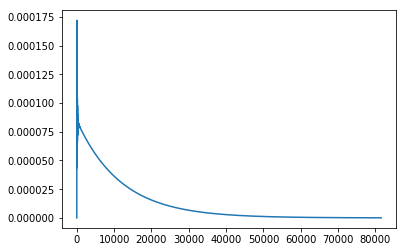

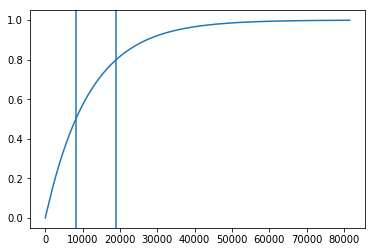

In [8]:
time2goal(G, 'Block', 'Block Aff1 Aff2')